<a href="https://www.kaggle.com/code/maysoonhelmy/traffic-sign-recognition-description?scriptVersionId=259738498" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow. keras.models import Sequential
from tensorflow .keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow. keras.applications import MobileNetV2
from tensorflow. keras.layers import GlobalAveragePooling2D
from tensorflow. keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn. metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn. metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

## Data Reading and Inspection

In [12]:
data_path = '/kaggle/input/gtsrb-german-traffic-sign'

train_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
meta_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')

train_df = train_df.merge(meta_df, on="ClassId", how="left")
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path_x,Path_y,ShapeId,ColorId,SignId
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Meta/20.png,0,0,1.1
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Meta/20.png,0,0,1.1
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Meta/20.png,0,0,1.1
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Meta/20.png,0,0,1.1
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Meta/20.png,0,0,1.1


In [13]:
# Dataset's Shape and Columns
print("Number of samples:", len(train_df))
print("Number of unique classes:", train_df['ClassId'].nunique())
print("Columns:", train_df.columns.tolist())
train_df.info()

Number of samples: 39209
Number of unique classes: 43
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path_x', 'Path_y', 'ShapeId', 'ColorId', 'SignId']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path_x   39209 non-null  object
 8   Path_y   39209 non-null  object
 9   ShapeId  39209 non-null  int64 
 10  ColorId  39209 non-null  int64 
 11  SignId   38759 non-null  object
dtypes: int64(9), object(3)
memory usage: 3.6+ MB


In [14]:
# Check Missing Values 
print("\nMissing values per column:")
print(train_df.isnull().sum())


Missing values per column:
Width        0
Height       0
Roi.X1       0
Roi.Y1       0
Roi.X2       0
Roi.Y2       0
ClassId      0
Path_x       0
Path_y       0
ShapeId      0
ColorId      0
SignId     450
dtype: int64


## Class Distribution

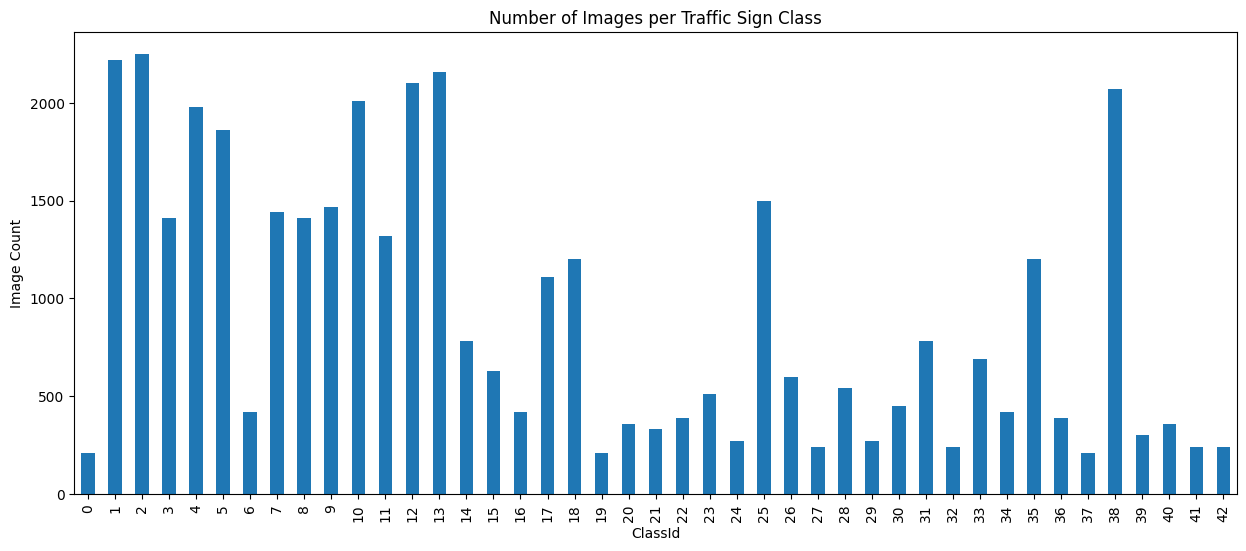

In [17]:
# Bar Chart for the distribution
plt.figure(figsize=(15,6))
train_df['ClassId'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Images per Traffic Sign Class")
plt.ylabel("Image Count")
plt.xticks(rotation=90)
plt.show()

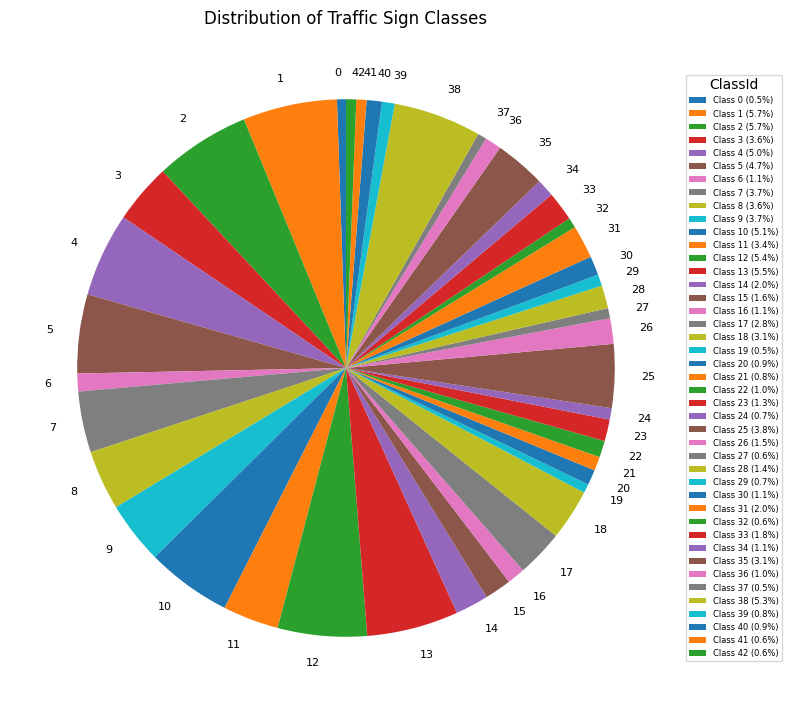

In [18]:
# Pie chart Distribution
class_counts = train_df['ClassId'].value_counts().sort_index()
total = class_counts.sum()

plt.figure(figsize=(8,8))
class_counts.plot(kind='pie', fontsize=8 ,startangle=90)
plt.title("Distribution of Traffic Sign Classes")
plt.ylabel("")
# Add the percentages of each label into the legend for better visualization
labels = [f"Class {cls} ({count/total*100:.1f}%)" for cls, count in class_counts.items()]
plt.legend( labels, title="ClassId",bbox_to_anchor=(1, 0.5), loc="center left", fontsize=6)
plt.tight_layout()
plt.show()

## Visualize and Understand the Images

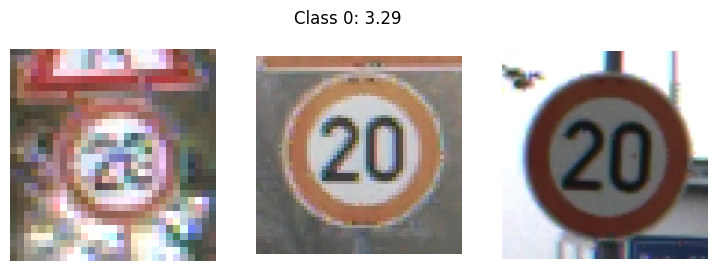

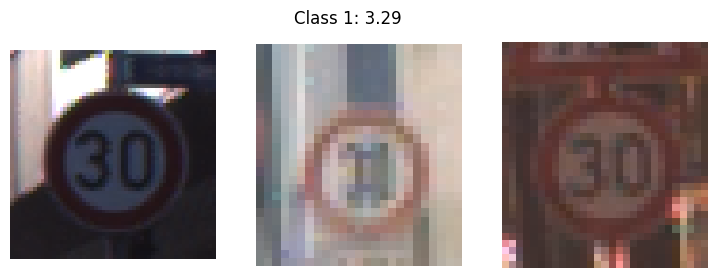

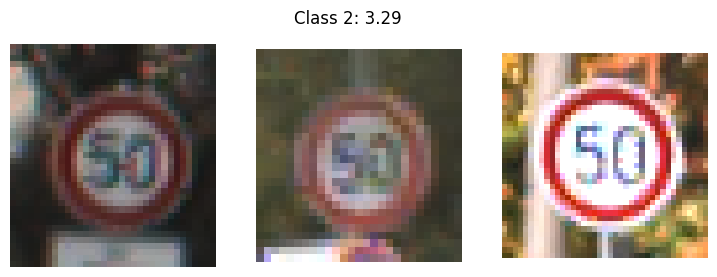

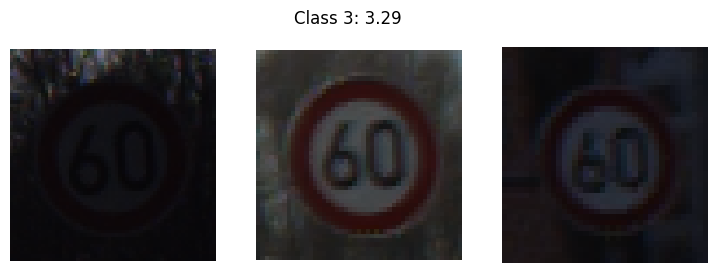

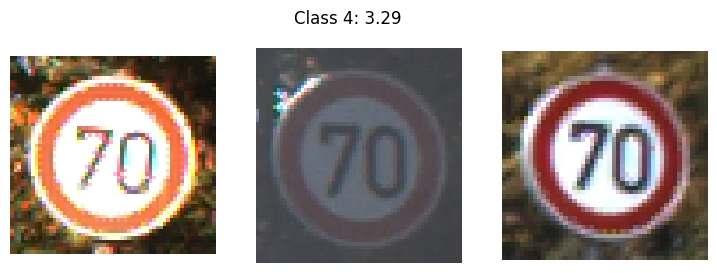

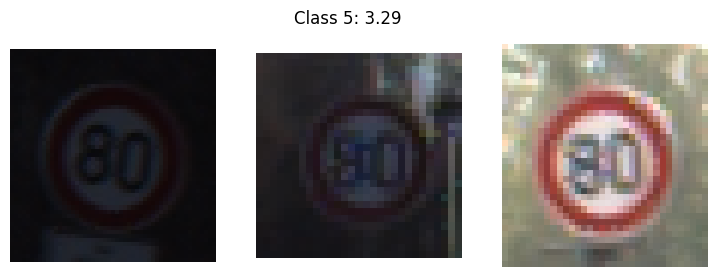

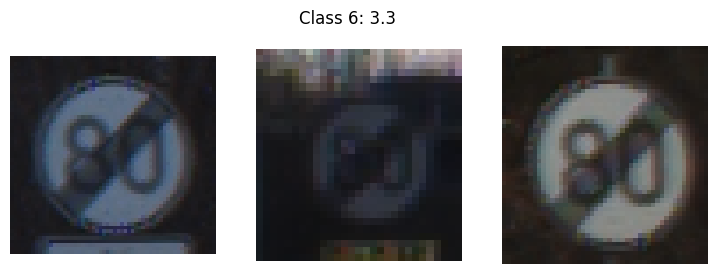

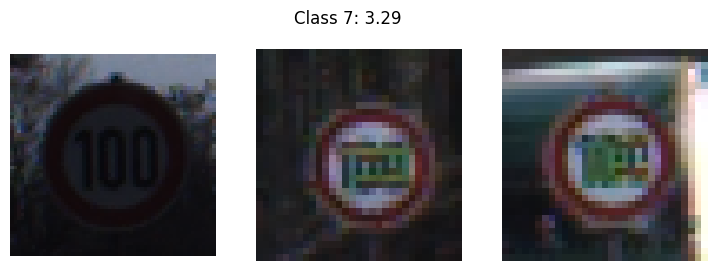

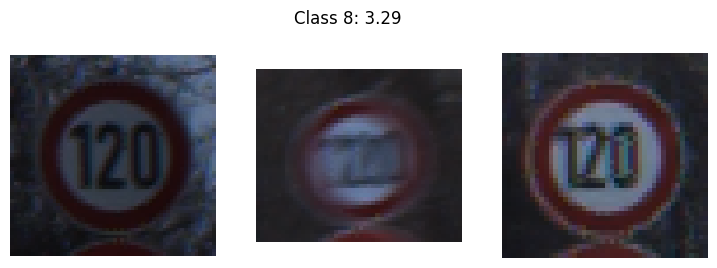

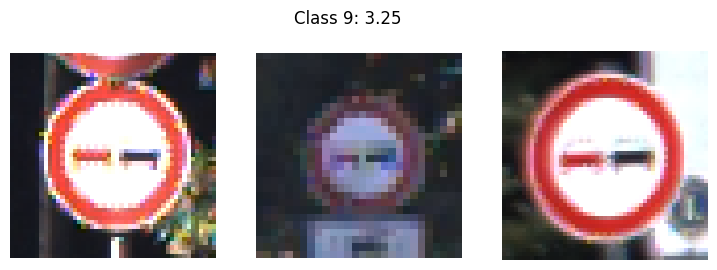

In [19]:
# Show 3 Samples for the first 10 classes 
classes = sorted(train_df['ClassId'].unique())
for class_id in classes[:10]:
    samples = train_df[train_df['ClassId'] == class_id].sample(3, random_state=42)
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    fig.suptitle(f"Class {class_id}: {samples['SignId'].iloc[0]}", fontsize=12)
    
    for idx, (i, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(data_path, row['Path_x'])
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
    plt.show()

In [20]:
# Image Size Statistics
sizes = []
for i in range(min(1000, len(train_df))):  
    img = Image.open(os.path.join(data_path, train_df['Path_x'].iloc[i]))
    sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=['Width', 'Height'])
display(sizes_df.describe())

,Width,Height
count,1000.000000,1000.000000
mean,50.714000,50.471000
std,20.757241,21.082163
min,25.000000,25.000000
25%,36.000000,35.000000
50%,45.000000,45.000000
75%,59.000000,59.000000
max,166.000000,170.000000


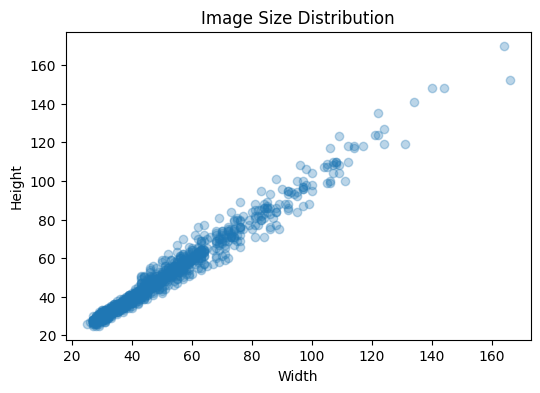

In [21]:
# Scatter plot of width vs height
plt.figure(figsize=(6,4))
plt.scatter(sizes_df['Width'], sizes_df['Height'], alpha=0.3)
plt.title("Image Size Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [22]:
# Check if any images are very small or very large
small_images = sizes_df[(sizes_df['Width'] < 20) | (sizes_df['Height'] < 20)]
large_images = sizes_df[(sizes_df['Width'] > 100) | (sizes_df['Height'] > 100)]
print(f"Small images: {len(small_images)}")
print(f"Large images: {len(large_images)}")

Small images: 0
Large images: 37


In [23]:
# Color Channel statistics 
R, G, B = [], [], []

for i in range(min(1000, len(train_df))):
    img = Image.open(os.path.join(data_path, train_df['Path_x'].iloc[i])).convert("RGB")
    arr = np.array(img) / 255.0  # normalize
    R.append(arr[:,:,0].mean())
    G.append(arr[:,:,1].mean())
    B.append(arr[:,:,2].mean())

print("Average normalized channel intensities (sample of 1000 images):")
print("Red  :", round(np.mean(R), 4))
print("Green:", round(np.mean(G), 4))
print("Blue :", round(np.mean(B), 4))


Average normalized channel intensities (sample of 1000 images):
Red  : 0.3836
Green: 0.3364
Blue : 0.331


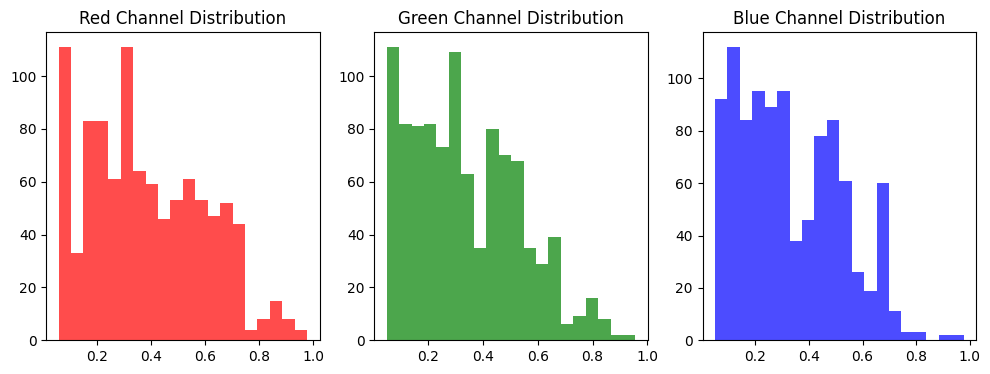

In [24]:
# Histogram of channel means
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(R, bins=20, color='r', alpha=0.7)
plt.title("Red Channel Distribution")
plt.subplot(1,3,2)
plt.hist(G, bins=20, color='g', alpha=0.7)
plt.title("Green Channel Distribution")
plt.subplot(1,3,3)
plt.hist(B, bins=20, color='b', alpha=0.7)
plt.title("Blue Channel Distribution")
plt.show()

In [25]:
# Calculate the Intra-class variance
class_variances = []

for class_id in sorted(train_df['ClassId'].unique()):
    samples = train_df[train_df['ClassId']==class_id].sample(min(50, len(train_df[train_df['ClassId']==class_id])), random_state=42)
    
    all_pixels = []
    for path in samples['Path_x']:
        img = Image.open(os.path.join(data_path, path)).convert("RGB")
        arr = np.array(img) / 255.0  
        all_pixels.append(arr.reshape(-1, 3))  
    
    all_pixels = np.vstack(all_pixels)  
    # calculate variance per channel
    r_var = all_pixels[:,0].var()
    g_var = all_pixels[:,1].var()
    b_var = all_pixels[:,2].var()
    overall_var = all_pixels.var()
    
    class_variances.append({
        "ClassId": class_id,
        "RedVariance": round(r_var, 6),
        "GreenVariance": round(g_var, 6),
        "BlueVariance": round(b_var, 6),
        "OverallVariance": round(overall_var, 6)
    })

variance_df = pd.DataFrame(class_variances)
display(variance_df.head())

,ClassId,RedVariance,GreenVariance,BlueVariance,OverallVariance
0,0,0.068295,0.084418,0.091083,0.082365
1,1,0.095074,0.096651,0.105678,0.099810
2,2,0.087972,0.082095,0.085595,0.086078
3,3,0.071021,0.079881,0.086177,0.079064
4,4,0.085109,0.079277,0.090423,0.085102


# Data PreProcessing

## Load Data & Prepare Data

In [45]:
data_path = '/kaggle/input/gtsrb-german-traffic-sign'

df_train = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Train.csv")
df_test = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")

In [46]:
# Add full paths column to access the image easier
df_train['full_path'] = df_train['Path'].apply(lambda x: os.path.join(data_path, x))
df_test['full_path'] = df_test['Path'].apply(lambda x: os.path.join(data_path, x))

In [47]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,full_path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,/kaggle/input/gtsrb-german-traffic-sign/Train/...
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,/kaggle/input/gtsrb-german-traffic-sign/Train/...
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,/kaggle/input/gtsrb-german-traffic-sign/Train/...
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,/kaggle/input/gtsrb-german-traffic-sign/Train/...
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,/kaggle/input/gtsrb-german-traffic-sign/Train/...


## Train - val split

In [48]:
# split
train_split, val_split = train_test_split(df_train,test_size=0.2,stratify=df_train['ClassId'],random_state=42)

In [49]:
# reset index 
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

## Image PreProcessing

In [50]:
# Resize Images to make all images a fixed size
IMG_SIZE = 64
BATCH_SIZE = 32

In [51]:
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.ensure_shape(img, (None, None, 3))  
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])         
    img = tf.cast(img, tf.float32) / 255.0       
    return img, label  

In [52]:
def augment(img, label):
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.random_hue(img, 0.1)  
    img = tf.image.random_jpeg_quality(img, 70, 95) 
    img = tf.image.rot90(img, k)
    return img, label

In [53]:
# Training Dataset 
train_ds = tf.data.Dataset.from_tensor_slices((train_split['full_path'].values, train_split['ClassId'].values))
train_ds = (train_ds .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).map(augment, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000)
    .batch(BATCH_SIZE) .prefetch(tf.data.AUTOTUNE))

In [54]:
# Validation Dataset 
val_ds = tf.data.Dataset.from_tensor_slices( (val_split['full_path'].values, val_split['ClassId'].values))
val_ds = (val_ds .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE) .prefetch(tf.data.AUTOTUNE))

In [55]:
# Test Dataset 
test_ds = tf.data.Dataset.from_tensor_slices((df_test['full_path'].values, df_test['ClassId'].values))
test_ds = (test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

In [56]:
# Check whether or not the datasets made are working
X_train, y_train = next(iter(train_ds))
X_val, y_val = next(iter(val_ds))
X_test, y_test = next(iter(test_ds)) 

# Print shapes
print("📊 Dataset Shapes:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

# Pixel range
print(f"\n✅ Pixel range: {X_train.numpy().min():.3f} to {X_train.numpy().max():.3f}")

📊 Dataset Shapes:
Train: X=(32, 64, 64, 3), y=(32,)
Val:   X=(32, 64, 64, 3), y=(32,)
Test:  X=(32, 64, 64, 3), y=(32,)

✅ Pixel range: 0.000 to 1.000


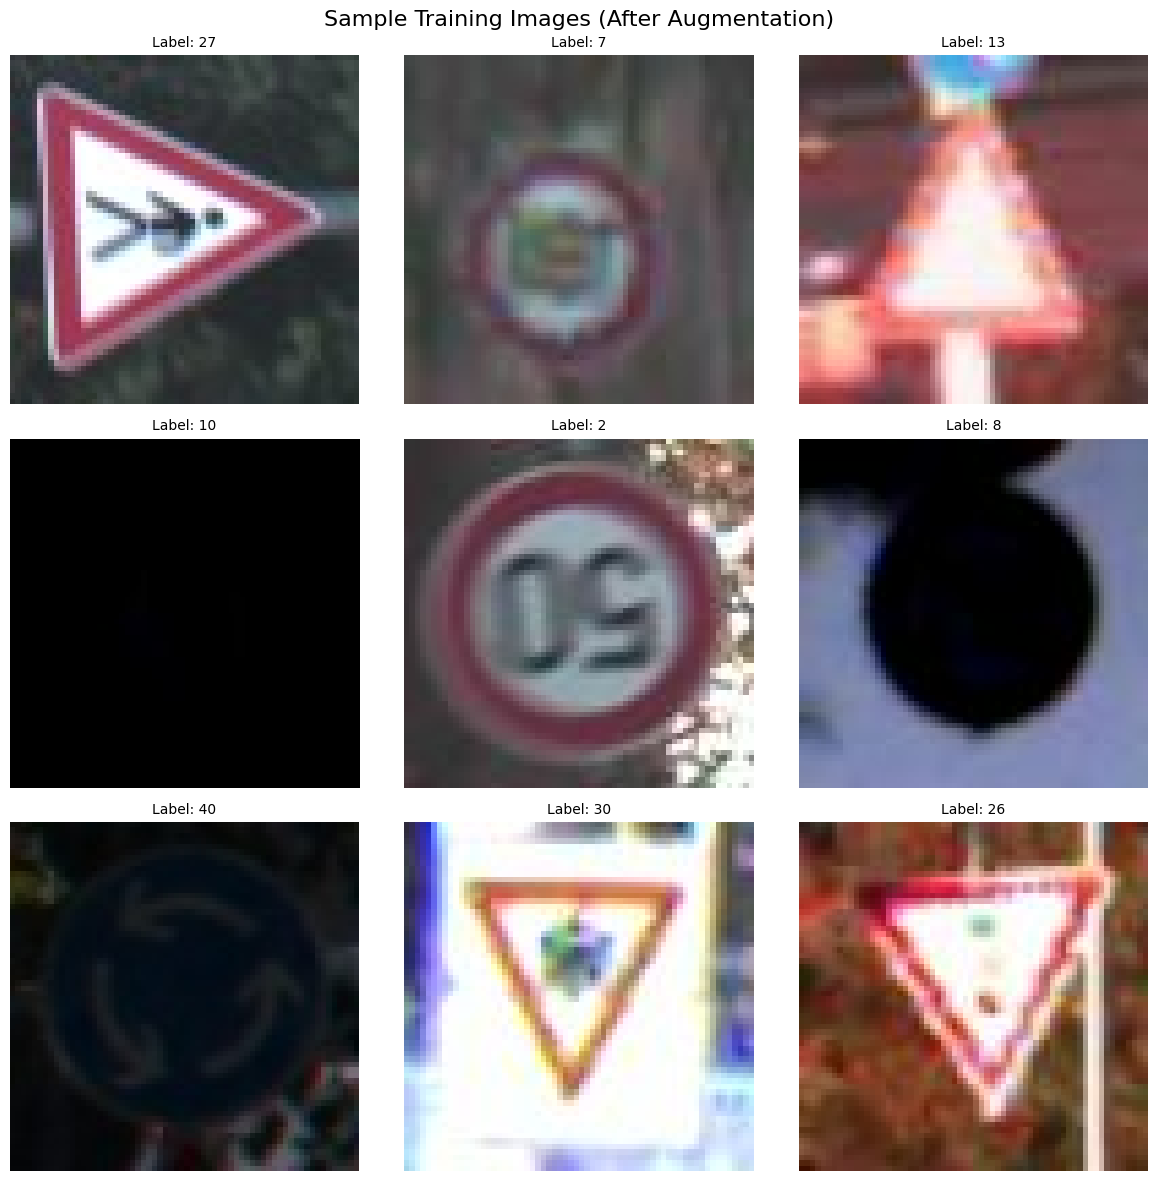

In [57]:
# Visualize Sample Training Images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i].numpy()}", fontsize=10)
    plt.axis("off")
plt.suptitle("Sample Training Images (After Augmentation)", fontsize=16)
plt.tight_layout()
plt.show()

# Model Development

## CNN Model

In [58]:
for x_batch, y_batch in train_ds.take(1):
    print("Input shape:", x_batch.shape) 
    print("Label shape:", y_batch.shape) 
    break

Input shape: (32, 64, 64, 3)
Label shape: (32,)


In [59]:
# Define model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    GlobalAveragePooling2D(), 
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  
])

In [60]:
# Compile
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
early_stop = EarlyStopping( monitor='val_loss',patience=5,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.2,patience=3,min_lr=1e-7)

In [62]:
# Compute steps
steps_per_epoch = len(train_split) // 32
validation_steps = len(val_split) // 32

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 980
Validation steps: 245


In [63]:
# Train CNN
history_custom = cnn_model.fit(train_ds,validation_data=val_ds,epochs=20,steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 121s 120ms/step - accuracy: 0.0877 - loss: 3.3793 - val_accuracy: 0.1333 - val_loss: 3.0108 - learning_rate: 0.0010
Epoch 2/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0000e+00 - loss: 2.6974 - val_accuracy: 0.1332 - val_loss: 3.0123 - learning_rate: 0.0010
Epoch 3/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.1399 - loss: 3.0405 - val_accuracy: 0.2055 - val_loss: 2.7340 - learning_rate: 0.0010
Epoch 4/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5714 - loss: 2.3543 - val_accuracy: 0.1962 - val_loss: 2.7485 - learning_rate: 0.0010
Epoch 5/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.2033 - loss: 2.8070 - val_accuracy: 0.2787 - val_loss: 2.4238 - learning_rate: 0.0010
Epoch 6/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4286 - loss: 1.9266 - val_accuracy: 0.2782 - val_loss: 2.4266 - learning_rate: 0.0010
Epoch 7/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.2620 - l

In [64]:
# Evaluate the CNN model on test set
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_ds, verbose=1)

print(f" CNN - Test Loss: {test_loss_cnn:.4f}")
print(f" CNN - Test Accuracy: {test_accuracy_cnn:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.4646 - loss: 1.6380
 CNN - Test Loss: 1.6523
 CNN - Test Accuracy: 0.4603


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


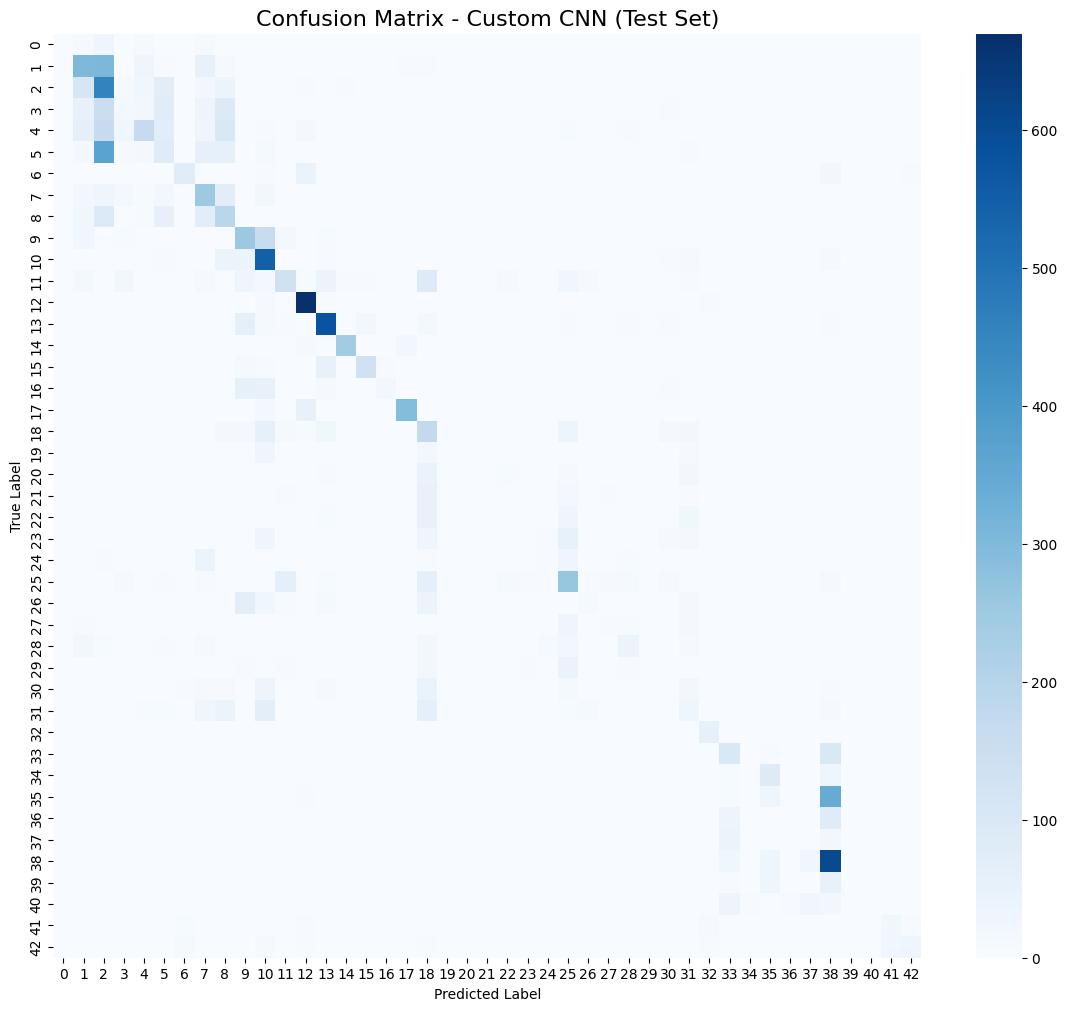

In [65]:
# True labels from test set
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

# Predictions from CNN
y_test_pred_probs_cnn = cnn_model.predict(test_ds)
y_test_pred_cnn = np.argmax(y_test_pred_probs_cnn, axis=1)

# Compute confusion matrix
cm_cnn = confusion_matrix(y_test_true, y_test_pred_cnn)

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(cm_cnn, cmap='Blues')
plt.title("Confusion Matrix - Custom CNN (Test Set)", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [66]:
print("📋 Classification Report - Custom CNN")
print(classification_report(y_test_true, y_test_pred_cnn, target_names=[f"Class {i}" for i in range(43)]))

📋 Classification Report - Custom CNN
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        60
     Class 1       0.45      0.42      0.44       720
     Class 2       0.28      0.61      0.38       750
     Class 3       0.14      0.04      0.06       450
     Class 4       0.57      0.26      0.35       660
     Class 5       0.20      0.13      0.16       630
     Class 6       0.75      0.51      0.61       150
     Class 7       0.40      0.56      0.47       450
     Class 8       0.29      0.43      0.34       450
     Class 9       0.46      0.53      0.49       480
    Class 10       0.48      0.83      0.61       660
    Class 11       0.55      0.32      0.41       420
    Class 12       0.82      0.97      0.89       690
    Class 13       0.75      0.81      0.78       720
    Class 14       0.96      0.89      0.93       270
    Class 15       0.83      0.66      0.73       210
    Class 16       0.72      0.15      0.25 

## MobileNetV2 Model

In [67]:
# Load pre-trained MobileNetV2 
base_model = MobileNetV2(
    weights='imagenet',           
    include_top=False,            
    input_shape=(64, 64, 3)       
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [68]:
# Add custom classifier on top
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),     
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  
])

In [69]:
# Compile
mobilenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
# Recompute steps 
steps_per_epoch = len(train_split) // BATCH_SIZE
validation_steps = len(val_split) // BATCH_SIZE

In [71]:
# Train
history_mobile = mobilenet_model.fit(train_ds, validation_data=val_ds,epochs=20,steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/20


E0000 00:00:1756890360.470528     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756890360.674259     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756890360.869366     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756890361.052497     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


980/980 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - accuracy: 0.3063 - loss: 2.5548 - val_accuracy: 0.2105 - val_loss: 3.1391 - learning_rate: 0.0010
Epoch 2/20


E0000 00:00:1756890402.773440     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756890402.955482     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.5714 - loss: 1.3222 - val_accuracy: 0.2028 - val_loss: 3.1792 - learning_rate: 0.0010
Epoch 3/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.6958 - loss: 1.0123 - val_accuracy: 0.1723 - val_loss: 3.3848 - learning_rate: 0.0010
Epoch 4/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5714 - loss: 1.4855 - val_accuracy: 0.1705 - val_loss: 3.3969 - learning_rate: 0.0010
Epoch 5/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8077 - loss: 0.6514 - val_accuracy: 0.8867 - val_loss: 0.3561 - learning_rate: 2.0000e-04
Epoch 6/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7143 - loss: 1.2139 - val_accuracy: 0.8858 - val_loss: 0.3637 - learning_rate: 2.0000e-04
Epoch 7/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8573 - loss: 0.4707 - val_accuracy: 0.9226 - val_loss: 0.2204 - learning_rate: 2.0000e-04
Epoch 8/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8571 - loss: 0

In [72]:
# Predict on test set
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_pred_probs = mobilenet_model.predict(test_ds)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step


In [73]:
# Final evaluation on test set
test_loss, test_accuracy = mobilenet_model.evaluate(test_ds, verbose=1)

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9333 - loss: 0.2418
Final Test Loss: 0.2566
Final Test Accuracy: 0.9277


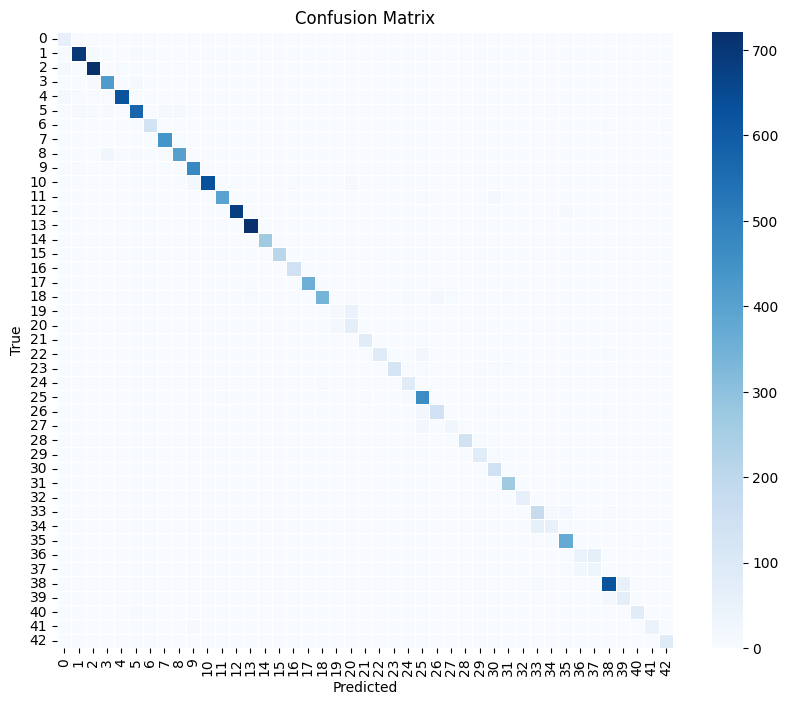

In [74]:
# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', cbar=True, square=True, linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [75]:
# Classification Report
report = classification_report(y_test_true, y_test_pred)

# Print
print("📋 Classification Report - MobileNetV2 (Test Set)")
print(report)

📋 Classification Report - MobileNetV2 (Test Set)
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        60
           1       0.97      0.97      0.97       720
           2       0.95      0.96      0.96       750
           3       0.90      0.93      0.92       450
           4       0.98      0.94      0.96       660
           5       0.96      0.91      0.93       630
           6       0.99      0.91      0.95       150
           7       0.96      0.98      0.97       450
           8       0.93      0.90      0.91       450
           9       0.95      0.99      0.97       480
          10       1.00      0.96      0.98       660
          11       0.99      0.95      0.97       420
          12       1.00      0.98      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.98      0.99       210
          16       0.98      0.9

## Compare custom CNN Model and Pretrained Model (MobileNetV2 Model)